# Load Stuff

In [15]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
import cv2

In [16]:
classes = {
    0: ("actinic keratoses and intraepithelial carcinomae(Cancer)"),
    1: ("basal cell carcinoma(Cancer)"),
    2: ("benign keratosis-like lesions(Non-Cancerous)"),
    3: ("dermatofibroma(Non-Cancerous)"),
    4: ("melanocytic nevi(Non-Cancerous)"),
    5: ("pyogenic granulomas and hemorrhage(Can lead to cancer)"),
    6: ("melanoma(Cancer)"),
}

In [17]:
# Paths
train_path = "dataset\\hmnist_28_28_RGB_train.csv"
test_path = "dataset\\hmnist_28_28_RGB_test.csv"

comp_train_path = "dataset\\hmnist_28_28_RGB_train_0e055.csv"
comp_test_path = "dataset\\hmnist_28_28_RGB_test_0e055.csv"

main_model_path = 'best_model.h5'
defended_model_path = 'best_model_defended.h5'

In [18]:
# Load train and test set into X and Y
train_set = pd.read_csv(train_path)
test_set = pd.read_csv(test_path)

y_train = train_set['label']
x_train = train_set.drop(columns=['label'])
x_train=np.array(x_train).reshape(-1,28,28,3)

y_test = test_set['label']
x_test = test_set.drop(columns=['label'])
x_test=np.array(x_test).reshape(-1,28,28,3)


In [19]:
# Load the pre-trained model
model = keras.models.load_model(main_model_path)
model.trainable = True
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
score = model.evaluate(x_test, y_test, verbose=0, batch_size=1)
print('Test loss:', score[0])
print('Test accuracy (%):', 100*score[1])

Test loss: 1.055915355682373
Test accuracy (%): 71.89216017723083


In [20]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 14, 14, 16)        64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0

# Attack

### Function to Make Pertubated Images 

In [21]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def create_compromised_image(image, epsilon, model_to_attack):
    image = tf.convert_to_tensor(image.reshape((1, 28, 28, 3)), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model_to_attack(image)
        label = tf.argmax(prediction, axis=1)
        loss = loss_object(label, prediction)

    gradient = tape.gradient(loss, image)
    perturbations = tf.sign(gradient)

    adversarial_image = image + epsilon*perturbations
    return adversarial_image


### Test Out Attack

1/1 [==============================] - 1s 725ms/step


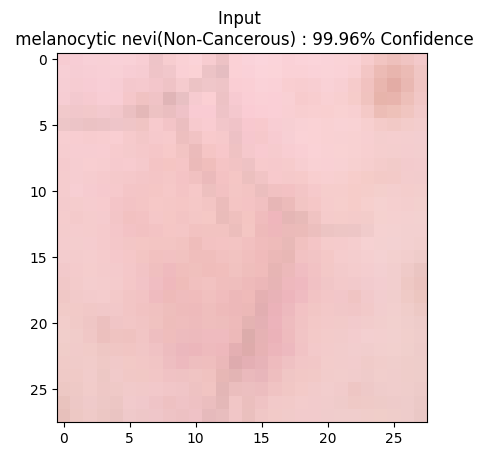

1/1 [==============================] - 0s 55ms/step


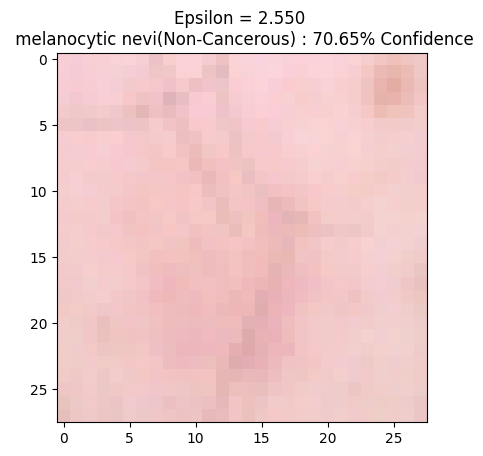

1/1 [==============================] - 0s 77ms/step


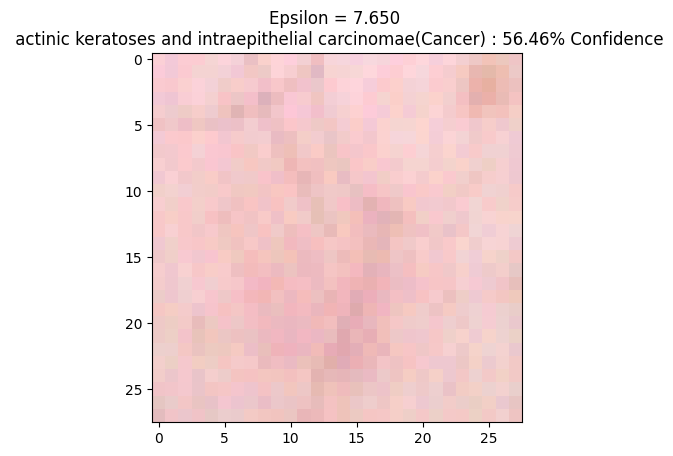

1/1 [==============================] - 0s 102ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


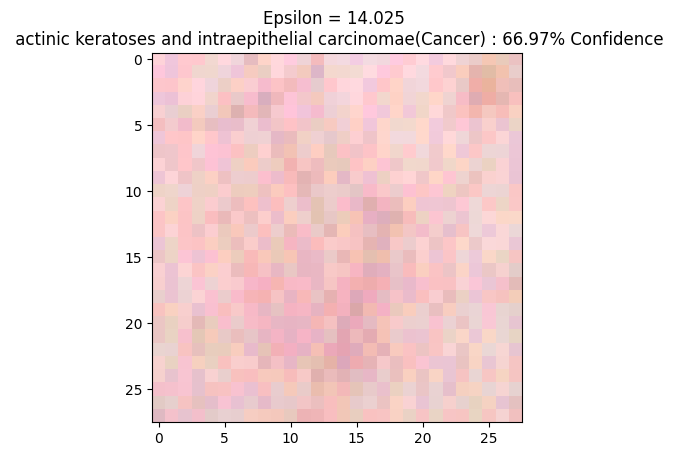

In [22]:
def display_images(new_image, description, model = model):
    #  Display the given image along with its predicted label and confidence.
    pred = model.predict(new_image)
    label = np.argmax(pred, axis=1)[0]
    label = classes[label]
    confidence = np.max(pred, axis=1)[0]
    plt.figure()
    plt.imshow(new_image[0]*0.5/255+0.5)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence*100))
    plt.show()

epsilons = np.array([0, 0.01, 0.03, 0.055])*255
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input') for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = create_compromised_image(x_test[0], eps, model)
    display_images(adv_x, descriptions[i])

### Test Attack on multiple images and plot the accuracy for different epsilons

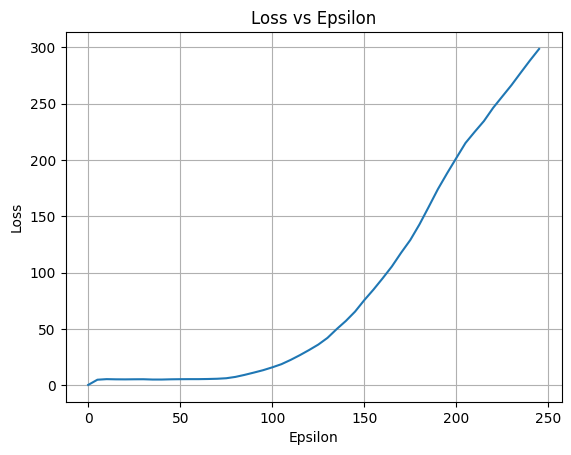

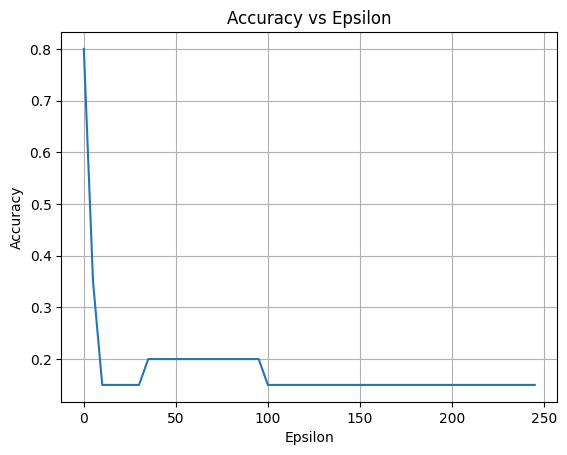

In [23]:
def epsilon_iter_attack(epsilon, length = 20, model = model):
    test_loss = []
    test_acc = []

    for eps in epsilon:
        x_test_compromised = []
        for i, img in enumerate(x_test[:length]):
            adv_x = create_compromised_image(img, eps, model)[0].numpy()
            x_test_compromised.append(adv_x)

        x_test_compromised = np.array(x_test_compromised)
        score = model.evaluate(x_test_compromised, y_test[:length], verbose=0, batch_size=1)
        test_loss.append(score[0])
        test_acc.append(score[1])
    return test_loss, test_acc

epsilon = np.linspace(0, 245, 50)
test_loss, test_acc = epsilon_iter_attack(epsilon)

plt.figure()
plt.plot(epsilon, test_loss)
plt.title('Loss vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Loss')
plt.grid()
plt.show()

plt.figure()
plt.plot(epsilon, test_acc)
plt.title('Accuracy vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

### Make Equivalent CSV file of Pertubated Images

In [24]:
def make_and_store_pertubated_images(og_path, comp_path, epsilon, model = model):

    og_df=pd.read_csv(og_path)

    labels = og_df['label']
    og_img = og_df.drop(columns=['label'])
    og_img=np.array(og_img).reshape(-1,28,28,3)

    # Create compromised dataset
    compromised_img = []
    epsilon = 0.055
    for i, img in enumerate(og_img):
        adv_x = create_compromised_image(img, epsilon*255, model).numpy()
        compromised_img.append(adv_x)
    compromised_img = np.array(compromised_img)

    # Evaluate compromised dataset
    score = model.evaluate(compromised_img, labels, verbose=0, batch_size=1)
    print('Test loss:', score[0])
    print('Test accuracy (%):', 100*score[1])

    # Save as csv
    compromised_img = compromised_img.reshape(-1, 28*28*3)
    compromised_img_with_labels = np.concatenate((compromised_img, np.array(labels)[:, None]), axis=1)
    comp_df = pd.DataFrame(compromised_img_with_labels)
    comp_df.columns = og_df.columns
    comp_df.to_csv(comp_path, index=False)


make_and_store_pertubated_images(train_path, comp_train_path, 0.055)
make_and_store_pertubated_images(test_path, comp_test_path, 0.055)

Test loss: 5.169366836547852
Test accuracy (%): 7.763355225324631
Test loss: 4.622622966766357
Test accuracy (%): 13.729405403137207


# Defence

### Load and Mix Pertubated Images With Normal images

In [25]:
og_train_df = pd.read_csv(train_path)
comp_train_df = pd.read_csv(comp_train_path)

og_test_df = pd.read_csv(test_path)
comp_test_df = pd.read_csv(comp_test_path)


# Merge the two datasets
merged_train_df = pd.concat([og_train_df, comp_train_df], ignore_index=True)
merged_test_df = pd.concat([og_test_df, comp_test_df], ignore_index=True)

# Shuffle the datasets
merged_train_df = merged_train_df.sample(frac=1).reset_index(drop=True)
merged_test_df = merged_test_df.sample(frac=1).reset_index(drop=True)

# Print the number of samples in each dataset
print("Number of samples in train set: {}".format(len(merged_train_df)))
print("Number of samples in test set: {}".format(len(merged_test_df)))

# Prepare images and labels
y_train_merged = merged_train_df['label']
x_train_merged = merged_train_df.drop(columns=['label'])

y_test_merged = merged_test_df['label']
x_test_merged = merged_test_df.drop(columns=['label'])

# Oversample the train set
oversample = RandomOverSampler()
x_train_merged,y_train_merged  = oversample.fit_resample(x_train_merged,y_train_merged)

# Reshape the train and test sets
x_train_merged = np.array(x_train_merged).reshape(-1,28,28,3)
x_test_merged = np.array(x_test_merged).reshape(-1,28,28,3)

Number of samples in train set: 16024
Number of samples in test set: 4006


### Data Augmentation for Training

In [26]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath=defended_model_path,
                                              monitor='val_accuracy', 
                                              mode='max',
                                              verbose=1,
                                              save_best_only=True)

defended_model = tf.keras.models.clone_model(model)
defended_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

defended_model.fit(x_train_merged, y_train_merged, epochs=10, batch_size=32, validation_split=0.2, callbacks=[callback])
defended_model = keras.models.load_model(defended_model_path)

Epoch 1/10
1871/1871 [==============================] - ETA: 0s - loss: 0.9780 - accuracy: 0.6482
Epoch 1: val_accuracy improved from -inf to 0.38927, saving model to best_model_defended.h5
1871/1871 [==============================] - 42s 20ms/step - loss: 0.9780 - accuracy: 0.6482 - val_loss: 1.5575 - val_accuracy: 0.3893
Epoch 2/10
   1/1871 [..............................] - ETA: 37s - loss: 0.3234 - accuracy: 0.9375

C:\Users\zengo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1871/1871 [==============================] - ETA: 0s - loss: 0.3555 - accuracy: 0.8798
Epoch 2: val_accuracy improved from 0.38927 to 0.40103, saving model to best_model_defended.h5
1871/1871 [==============================] - 41s 22ms/step - loss: 0.3555 - accuracy: 0.8798 - val_loss: 1.3388 - val_accuracy: 0.4010
Epoch 3/10
1869/1871 [============================>.] - ETA: 0s - loss: 0.2349 - accuracy: 0.9214
Epoch 3: val_accuracy improved from 0.40103 to 0.64615, saving model to best_model_defended.h5
1871/1871 [==============================] - 45s 24ms/step - loss: 0.2349 - accuracy: 0.9214 - val_loss: 1.0414 - val_accuracy: 0.6462
Epoch 4/10
1871/1871 [==============================] - ETA: 0s - loss: 0.1864 - accuracy: 0.9381
Epoch 4: val_accuracy did not improve from 0.64615
1871/1871 [==============================] - 43s 23ms/step - loss: 0.1864 - accuracy: 0.9381 - val_loss: 0.7523 - val_accuracy: 0.6097
Epoch 5/10
1869/1871 [============================>.] - ETA: 0s - loss:

### Filter Input Defence

In [27]:
def average_filter(img):
    kernel = np.ones((2,2),np.float32)/4
    return cv2.filter2D(img,-1,kernel)

### Test Defended Model 

In [28]:
print('Original dataset:')
score_og = model.evaluate(x_test, y_test, verbose=0, batch_size=1)
score_defend = defended_model.evaluate(x_test, y_test, verbose=0, batch_size=1)
score_df = pd.DataFrame({'Original': score_og, 'Defended': score_defend}, index=['Loss', 'Accuracy'])
print(score_df)


y_test_compromised = comp_test_df['label']
x_test_compromised = comp_test_df.drop(columns=['label'])
x_test_compromised = np.array(x_test_compromised).reshape(-1,28,28,3)
print('\nCompromised dataset:')
score_og = model.evaluate(x_test_compromised, y_test_compromised, verbose=0, batch_size=1)
score_defend = defended_model.evaluate(x_test_compromised, y_test_compromised, verbose=0, batch_size=1)
score_df = pd.DataFrame({'Original': score_og, 'Defended': score_defend}, index=['Loss', 'Accuracy'])
print(score_df)


x_test_compromised_filtered = np.array([average_filter(img) for img in x_test_compromised])
print('\nCompromised dataset filtered:')
score_og = model.evaluate(x_test_compromised_filtered, y_test_compromised, verbose=0, batch_size=1)
score_defend = defended_model.evaluate(x_test_compromised_filtered, y_test_compromised, verbose=0, batch_size=1)
score_df = pd.DataFrame({'Original': score_og, 'Defended': score_defend}, index=['Loss', 'Accuracy'])
print(score_df)


print('\nMerged dataset:')
score_og = model.evaluate(x_test_merged, y_test_merged, verbose=0, batch_size=1)
score_defend = defended_model.evaluate(x_test_merged, y_test_merged, verbose=0, batch_size=1)
score_df = pd.DataFrame({'Original': score_og, 'Defended': score_defend}, index=['Loss', 'Accuracy'])
print(score_df)

Original dataset:
          Original  Defended
Loss      1.055915  1.064335
Accuracy  0.718922  0.724913

Compromised dataset:
          Original  Defended
Loss      4.622623  1.306802
Accuracy  0.137294  0.705941

Merged dataset:
          Original  Defended
Loss      2.839264  1.185569
Accuracy  0.428108  0.715427

Compromised dataset filtered:
          Original  Defended
Loss      3.794748  1.223368
Accuracy  0.236645  0.708937
